In [1]:
import pickle

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier

In [2]:
# Load preprocessed dataset

PREPROCESSED_DF_PATH = 'preprocessed_applications_df.dataframe.pd'
main_df = pickle.load( open(PREPROCESSED_DF_PATH, 'rb') )

In [3]:
# Leave only 'naive' features: age, gender, region, monthlyincome, monthlycost, education, family status

naive_features = [
    'days_from_birth',
    'gender',
    'region', 'binned_region', 
    'monthlyincome', 'monthlycost',
    'fam_status', 'binned_fam_status',
    'df'  # target featuer
]
naive_df = main_df[ naive_features ]

In [4]:
# Convert several columns to 'category' dtype

category_features = ['gender', 'binned_region', 'binned_fam_status']

for feature_name in category_features:
    naive_df[feature_name] = naive_df[feature_name].astype('category')

In [5]:
# Apply standard scaler (z-transform)

standard_scl = StandardScaler()

features_to_scale = ['days_from_birth', 'monthlyincome', 'monthlycost']
scaled_data = standard_scl.fit_transform( naive_df[features_to_scale] )

naive_df.loc[:, 'days_from_birth'] = scaled_data[:, 0]
naive_df.loc[:, 'monthlyincome'] = scaled_data[:, 1]
naive_df.loc[:, 'monthlycost'] = scaled_data[:, 2]

In [6]:
# Encode binned features

features_to_encode = ['gender', 'binned_region', 'binned_fam_status']
naive_df = pd.get_dummies( naive_df, columns=features_to_encode, drop_first=True )

# Encode train label
train_labels = naive_df['df'].map({
    'bad': 0, 'good': 1
}).dropna()

In [7]:
def draw_learning_curve(estimator, X_tr, y_tr):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X_tr, y_tr, train_sizes=np.linspace(0.1, 1.0, 4), cv=3
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    plt.grid()
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1, color="r"
    )
    plt.fill_between(
        train_sizes,
        val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std,
        alpha=0.1, color="g"
    )
    plt.plot(
        train_sizes,
        train_scores_mean,
        'o-', color="r", label="Training score"
    )
    plt.plot(
        train_sizes,
        val_scores_mean,
        'o-', color="g", label="Cross-validation score"
    )
    plt.legend(loc="best")
    plt.show()

[[   0  330]
 [   0 1002]]


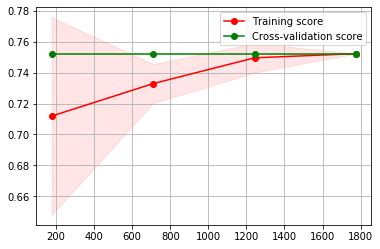

[[   0  330]
 [   0 1002]]


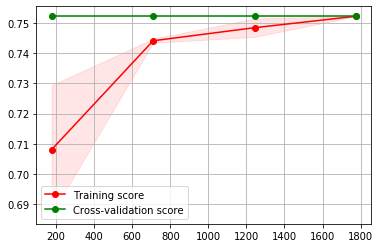

[[   0  330]
 [   0 1002]]


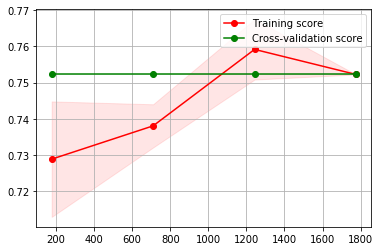

In [9]:
# Stratified CV

train_df = naive_df[ naive_df['df'].isnull() == False ]
train_df = train_df.drop( ['df'], axis=1 )

skf = StratifiedKFold(
    n_splits=3,
    shuffle=True
)

for train_idx, val_idx in skf.split(train_df, train_labels):
    X_tr, X_val = train_df.iloc[train_idx, :], train_df.iloc[val_idx, :]
    y_tr, y_val = train_labels.iloc[train_idx], train_labels.iloc[val_idx]
    
    # Not enough variance to explain the data
    lr_model = LogisticRegression(
        C=0.001,
        solver='lbfgs',
        n_jobs=-1
    )
    lr_model.fit(X_tr, y_tr)
    lr_val_pred = lr_model.predict(X_val)
    print(confusion_matrix(y_val, lr_val_pred))
    draw_learning_curve( lr_model, X_tr, y_tr )

#     f1: 0.0:0.2, 1.0:0.8
#     lgbm_model = LGBMClassifier(
#         learning_rate=0.05,
#         metric='recall',
#         objective='binary',
#         num_leaves=500,
#         max_depth=250,
#         n_estimators=1000,
#         scale_pos_weight=5,
#         n_jobs=4,
#     )
#     lgbm_model.fit(X_tr, y_tr)
#     lgbm_val_pred = lgbm_model.predict(X_val)
#     print(confusion_matrix(y_val, lgbm_val_pred))
# #     print(classification_report(y_val, lgbm_val_pred))
#     draw_learning_curve( lgbm_model, X_tr, y_tr )

[[   1  395]
 [   0 1203]]


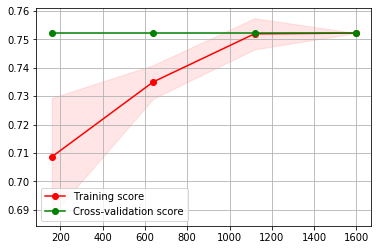

[[   1  395]
 [   0 1203]]


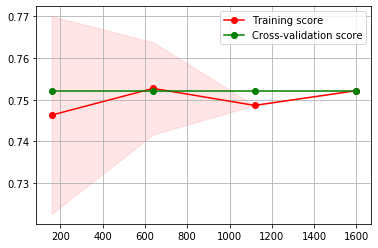

[[   1  395]
 [   0 1203]]


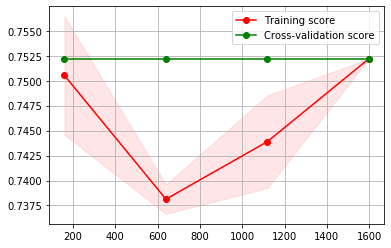

In [12]:
# Stratified Shuffle CV

sss = StratifiedShuffleSplit(
    n_splits=3,
    test_size=0.4,
)

for train_idx, val_idx in sss.split(train_df, train_labels):
    X_tr, X_val = train_df.iloc[train_idx, :], train_df.iloc[val_idx, :]
    y_tr, y_val = train_labels.iloc[train_idx], train_labels.iloc[val_idx]
    
    # Not enough variance to explain the data
    model_logreg = LogisticRegression(
        C=0.04,
        solver='lbfgs',
        max_iter=1000,
        n_jobs=-1
    )
    model_logreg.fit( X_tr, y_tr )
    logreg_val_pred = model_logreg.predict( X_val )
#     print(classification_report(y_val, logreg_val_pred))
    print(confusion_matrix(y_val, logreg_val_pred))
    draw_learning_curve( lr_model, X_tr, y_tr )

#     f1: 0.0:0.2, 1.0:0.8
#     lgbm_model = LGBMClassifier(
#         learning_rate=0.05,
#         metric='recall',
#         objective='binary',
#         num_leaves=500,
#         max_depth=250,
#         n_estimators=1000,
#         scale_pos_weight=5,
#         n_jobs=4,
#     )
#     lgbm_model.fit(X_tr, y_tr)
#     lgbm_val_pred = lgbm_model.predict(X_val)
# #     display( pd.Series(lgbm_val_pred).value_counts() )     
#     print(confusion_matrix(y_val, lgbm_val_pred))
# #     print(classification_report(y_val, lgbm_val_pred))
#     draw_learning_curve( lgbm_model, X_tr, y_tr )    

In [10]:
# Feature importances

lgbm_model = LGBMClassifier(
    learning_rate=0.05,
    metric='recall',
    objective='binary',
    num_leaves=500,
    max_depth=250,
    n_estimators=1000,
    scale_pos_weight=5,
    n_jobs=4,
)
lgbm_model.fit(X_tr, y_tr)
display(
    pd.DataFrame({
        'imp_name': train_df.columns,
        'imp_value': lgbm_model.booster_.feature_importance(importance_type='gain'),
    }).sort_values('imp_value', ascending=False)
)

,imp_name,imp_value
0,days_from_birth,17710.272379
2,monthlyincome,8464.744314
3,monthlycost,7670.087091
1,region,6829.490372
4,fam_status,1571.855154
5,gender_2,1086.629987
8,binned_fam_status_2,695.506884
7,binned_region_3,583.874688
6,binned_region_2,489.663288
9,binned_fam_status_3,0.000000
